# Netflix Recommendation System

In [11]:
# Load libraries
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Access Dataset

In [15]:
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['combined_data_1.txt',
#         'combined_data_2.txt',
#          'combined_data_3.txt',
#          'combined_data_4.txt'
        ]

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['Movie_Id', 'Cust_Id','Rating','date'])
# Drop date column
df = df.drop('date', axis = 1)
print(df.nunique())
df

Opening file: combined_data_1.txt
Movie_Id      4499
Cust_Id     470758
Rating           5
dtype: int64


,Movie_Id,Cust_Id,Rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3
...,...,...,...
24053759,4499,2591364,2
24053760,4499,1791000,2
24053761,4499,512536,5
24053762,4499,988963,3


### Shape and type of dataset

In [24]:

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])
print(type(df['Movie_Id']))
print(type(df['Cust_Id']))
print(type(df['Rating']))



Full dataset shape: (24053764, 3)
-Dataset examples-
          Movie_Id  Cust_Id  Rating
0                1  1488844       3
5000000        996   501954       2
10000000      1962   404654       5
15000000      2876   886608       2
20000000      3825  1193835       2
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Rating overview

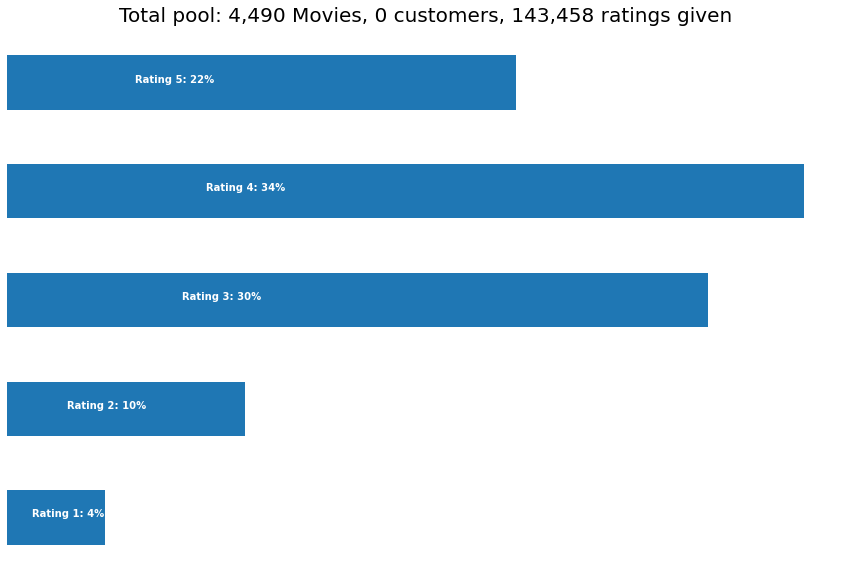

In [46]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: 4,490 Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')
    

### Converting Data Types 

In [26]:
df['Movie_Id'] = df['Movie_Id'].astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df['Rating'] = df['Rating'].astype(float)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Movie_Id  Cust_Id  Rating
0                1  1488844     3.0
5000000        996   501954     2.0
10000000      1962   404654     5.0
15000000      2876   886608     2.0
20000000      3825  1193835     2.0


## Data Slicing to reduce size of data

In [27]:
_filter = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(_filter)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(_filter)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


## Difference between data shape before and after

In [30]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Movie_Id  Cust_Id  Rating
693              3   712664     5.0
6931106       1384  1299309     5.0
13857613      2660   400155     3.0
20762607      3923   466962     4.0


## Pivot Tabel

In [31]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


### Access Movies titles file

In [32]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation System "collaborative Filtering"

## Singular Value Decompostion 

In [34]:
# load surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [37]:

reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.99773974, 1.00186188, 0.98960726, 0.99761667, 0.99805417]),
 'test_mae': array([0.80598393, 0.80707663, 0.79509536, 0.80212011, 0.79506179]),
 'fit_time': (11.406669616699219,
  10.833056688308716,
  10.74279236793518,
  10.927114963531494,
  13.313436031341553),
 'test_time': (0.39157819747924805,
  0.39620113372802734,
  0.531705379486084,
  0.38114380836486816,
  0.5007901191711426)}

### Explore what one user liked to watch 

In [38]:
# User 785318 
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

### predict what he will like to watch and estimated rating

In [39]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                   Name  Estimate_Score
1276  1988.0                    Red Dwarf: Series 3        5.000000
1551  1983.0                            Black Adder        4.863610
2113  2002.0                                Firefly        4.794967
2464  1984.0                     This Is Spinal Tap        4.665142
871   1954.0                          Seven Samurai        4.664717
2101  1994.0                 The Simpsons: Season 6        4.653580
3443  2004.0  Family Guy: Freakin' Sweet Collection        4.632508
174   1992.0                         Reservoir Dogs        4.627532
4391  1993.0                       Army of Darkness        4.624925
2553  1975.0          The Rocky Horror Picture Show        4.614436


## Recommend with Pearsons' R correlations to clustering similar movies

In [42]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

## Predict Similar Movies

In [44]:
recommend("Inu-Yasha", 0)


For movie (Inu-Yasha)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                               Name  count     mean
 1.000000                          Inu-Yasha   1883 4.554434
 0.923685                 Foyle's War: Set 2   2475 4.249293
 0.906828              Love in the Afternoon   2370 3.540506
 0.899746 Stoked: The Rise and Fall of Gator   2095 3.422912
 0.883783                       Regular Guys   1931 3.372864
 0.877944                           Together   3958 3.889843
 0.860688                 Spencer's Mountain   2624 3.848323
 0.854868                         Live Flesh   6072 3.600626
 0.839446                        Fever Pitch   2948 2.978290
 0.836660                 Cries and Whispers   2041 3.587457


In [45]:
recommend("Love in the Afternoon", 0)

For movie (Love in the Afternoon)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                           Name  count     mean
 1.000000                          Love in the Afternoon   2370 3.540506
 0.906828                                      Inu-Yasha   1883 4.554434
 0.817612                           Yu-Gi-Oh!: The Movie   3173 3.331547
 0.783903                          Escaflowne: The Movie   1992 3.629016
 0.741700       Captain Pantoja and the Special Services   1801 3.417546
 0.728322 Neon Genesis Evangelion: The End of Evangelion   2375 3.911158
 0.727858           Winnie the Pooh: Springtime with Roo   2190 3.768037
 0.722966                   Superbabies: Baby Geniuses 2   2983 2.851157
 0.684921                   The Education of Little Tree   1913 3.690016
 0.679832                     King of the Hill: Season 3   2339 3.849508
